# Pypulseq-CEST
## How to and C++ integration

- **aim**: implement pulseq-CEST for python
- **procedure**: 
    - optimize pypulseq
    - wrap C++ functions of the Simulation with SWIG
- **addition**:
    - implement pure python simulation BMCSim for comparison and pure python usability
- **current status**:
    - pypulseq: a few bugfixes, workaround for version dissimilarities
    - functional simulation with value discrepancies of less than $10^{-2}$
    - debugging CEST pool simulation in both Sim-files

### Pypulseq
- similar to pulseq: as an example view [write_APTW_seq.py](../example/write_APTW_seq.py)
- **aim**:
    - usability for simple information handling (read files)
    - file writing 
- readability for version 1.3 with simple information handling applied
- bugfixes for proper RF handling underway

### Simulation wrapping
- wrappers for C++ code with [SWIG](http://www.swig.org/) and the setuptools [(distutils)](https://docs.python.org/3/library/distutils.html) package 
- the necessary files can be found in the [src](../src) folder:
    - .cpp and .h files contain the necessary C++ functions
    - .i files contain the information for SWIG to create the .cxx wrapper files
    - setup.py files contain the code to compile python packages
- wrapping and compilation can be accomplished by running the following commands
    ```
    swig -c++ -python SimPulseqSBB.i
    swig -c++ -python ExternalSequence.i
    python setup.py install
    ```
    - note: requires SWIG and for Windows VisualC++ (currently only runs on Windows)
- 2 modules are created: SimPulseqSBB and ExternalSequence
    - to create just either one of the modules, use setup_sim.py or setup_ext.py respectively

### Brief introduction on SWIG definition files
*minimal example (not working code):*

```Cpp
%module SimPulseqSBB // Module Name

%{
#define SWIG_FILE_WITH_INIT
#include <functional>   // packages that the files we want to use need
#include "SimulationParameters.h"   // also the .h files if another file needs it, even if it is included below"
#define _USE_MATH_DEFINES   // other definitions used by included files
}

%include <std_vector.i>   // .i files SWIG needs to wrap properly
%include <eigen.i>   // other .i files you want swig to wrap as well

%template(vectorMatrixXd) std::vector<Eigen::MatrixXd>;   // for SWIG to handle templates correctly if used directly

%eigen_typemaps(Eigen::VectorXd)   // typemaps for variables that need special handling between languages

%rename(NoLineshape) None;   // for variables that could cause problems between languages

%include "SimPulseqSBB.h"  // the .h files that define the functions you want to use in python
```
- setup with distutils as an external module (see documentation and [setup.py](../src/setup.y))

### Simulation example


In [10]:
'''reset variables'''
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [11]:
''' set parameters '''

# path to seq-file
seq_file = 'example/example_APTw_m.seq'
# scanner parameters
b0 = 3  # field strength [T]
gamma = 267.5153  # gyromagnetic ratio [rad / uT]
# optional
b0_inhom = 0.0
rel_b1 = 1

# # Water properties(standard 3 T)
f_w = 1  # proton fraction
try:
    if round(b0) < 4:
        r1_w = 1 / 1.3  # Hz 1.31
        r2_w = 1 / (75e-3)  # Hz 71e-3
    elif 4 < round(b0) < 9:  # 7T
        r1_w = 1 / 1.67  # Hz
        r2_w = 1 / (43e-3)  # Hz
    elif round(b0) >= 9:  # 9.4 T and above
        r1_w = 1 / 2.0  # Hz
        r2_w = 1 / (35e-3)  # Hz
except ValueError:
    print('B0 field strength of ' + str(b0) + 'T: No implementation possible.')

# # CEST pools according to https: // doi.org / 10.1016 / j.neuroimage.2017.04.045,
# pool 1 Amide
r1_a = r1_w
r2_a = 1 / 100e-3
f_a = 50e-3/111 # fraction
dw_a = 3.5  # chemical shift from water [ppm]
k_a = 40  # exchange rate[Hz]

# pool 2 creatine
r1_c = r1_w
r2_c = 1 / 170e-3
f_c = 25e-3/111 # fraction
dw_c = 2  # chemical shift from water [ppm]
k_c = 1000  # exchange rate[Hz]

 # OPTIONAL MT pool
r1_mt = 1
r2_mt = 1e5
k_mt = 23
f_mt = 0.0500
dw_mt = -2 #0
lineshape_mt = 'Lorentzian' #'SuperLorentzian'

scale = 0.5


In [12]:
''' store parameters '''

import sys
sys.path.insert(1, '../')
from params import Params

seq_file = '../' + seq_file
# set parameter values
sp = Params()
sp.set_water_pool(r1_w, r2_w, f_w)
# for each cest pool set a pool in the params
r1 = [x for x in dir() if x[:2] == 'r1' and x != 'r1_w' and x != 'r1_mt']
r2 = [x for x in dir() if x[:2] == 'r2' and x != 'r2_w' and x != 'r2_mt']
k = [x for x in dir() if x[0] == 'k' and x != 'k_w' and x != 'k_mt']
f = [x for x in dir() if x[0] == 'f' and x != 'f_w' and x != 'f_mt']
dw = [x for x in dir() if x[:2] == 'dw' and x != 'dw_w' and x != 'dw_mt']
for pool in range(len(r1)):
    sp.set_cest_pool(eval(r1[pool]), eval(r2[pool]), eval(k[pool]), eval(f[pool]), eval(dw[pool]))
if 'r1_mt' in dir():
    sp.set_mt_pool(r1_mt, r2_mt, k_mt, f_mt, dw_mt, lineshape_mt)
print(sp.cest_pools)
sp.set_m_vec(scale)
sp.set_scanner(b0, gamma, b0_inhom, rel_b1)
if 'verbose' in dir():
    sp.set_options(verbose)
if 'reset_init_mag' in dir():
    sp.set_options(reset_init_mag)
if 'max_pulse_samples' in dir():
    sp.set_options(max_pulse_samples)

[{'r1': 0.7692307692307692, 'r2': 10.0, 'k': 40, 'f': 0.00045045045045045046, 'dw': 3.5}, {'r1': 0.7692307692307692, 'r2': 5.88235294117647, 'k': 1000, 'f': 0.00022522522522522523, 'dw': 2}]


In [13]:
''' run simulation '''
from parse_params import parse_sp
from SimPulseqSBB import SimPulseqSBB

sp_sim = parse_sp(sp, seq_file)

SimPulseqSBB(sp_sim, seq_file)
m_out = sp_sim.GetFinalMagnetizationVectors()
mz = m_out[6, :]
print(mz)

[0.99995696 0.79355318 0.78776478 0.78109683 0.77336726 0.76434587
 0.75374678 0.74120154 0.72624433 0.70828083 0.68655706 0.66012799
 0.62784431 0.58838163 0.54039121 0.48287872 0.41593144 0.34167472
 0.26450286 0.18761068 0.06771723 0.06771723 0.18761068 0.26450286
 0.34167472 0.41593144 0.48287872 0.54039121 0.58838163 0.62784431
 0.66012799 0.68655706 0.70828083 0.72624433 0.74120154 0.75374678
 0.76434587 0.77336726 0.78109683 0.78776478 0.79355318]


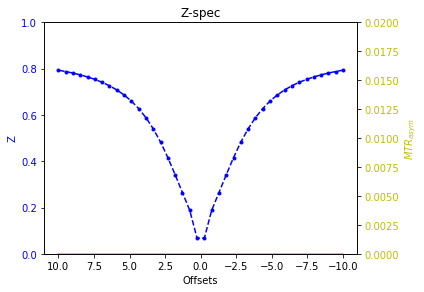

In [14]:
from plot import plot_z
import matplotlib.pyplot as plt

%matplotlib inline
fig = plot_z(mz, seq_file=seq_file, plot_mtr_asym=True)
plt.show()